In [1]:
import os
import shutil
from tqdm import tqdm

# --- CONFIGURATION ---
# Path where your data is currently stored in Drive
DRIVE_SOURCE_PATH = '/content/drive/MyDrive/data/data/chest_xray'

# Path where we want to copy it (Fast Local SSD)
LOCAL_DEST_PATH = '/content/temp_chest_xray'

def copy_dataset_locally(source, dest):
    if os.path.exists(dest):
        print(f"Data already exists at {dest}. Skipping copy.")
        return

    print(f"Scanning files in {source}...")
    # 1. Count total files for the progress bar
    total_files = 0
    for root, dirs, files in os.walk(source):
        total_files += len(files)

    print(f"Found {total_files} files. Starting copy to {dest}...")

    # 2. Copy files with a progress bar
    with tqdm(total=total_files, unit='img', desc='Copying Data') as pbar:
        for root, dirs, files in os.walk(source):
            # Create destination folder structure
            rel_path = os.path.relpath(root, source)
            dest_path = os.path.join(dest, rel_path)
            os.makedirs(dest_path, exist_ok=True)

            for file in files:
                src_file = os.path.join(root, file)
                dst_file = os.path.join(dest_path, file)

                # Copy the file
                shutil.copy2(src_file, dst_file)
                pbar.update(1)

    print("\nCopy Complete! Training will now be 10x-50x faster.")

# Run the function
copy_dataset_locally(DRIVE_SOURCE_PATH, LOCAL_DEST_PATH)

Scanning files in /content/drive/MyDrive/data/data/chest_xray...
Found 5880 files. Starting copy to /content/temp_chest_xray...


Copying Data: 100%|██████████| 5880/5880 [02:23<00:00, 40.99img/s] 


Copy Complete! Training will now be 10x-50x faster.


Found 5216 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 808ms/step - binary_accuracy: 0.7464 - loss: 0.6021 - precision: 0.9149 - recall: 0.7267 - val_binary_accuracy: 0.7688 - val_loss: 0.4855 - val_precision: 0.7345 - val_recall: 0.9951
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 745ms/step - binary_accuracy: 0.8934 - loss: 0.3980 - precision: 0.9634 - recall: 0.8887 - val_binary_accuracy: 0.8844 - val_loss: 0.3835 - val_precision: 0.8807 - val_recall: 0.9458
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 754ms/step - binary_accuracy: 0.9004 - loss: 0.3719 - precision: 0.9673 - recall: 0.8968 - val_binary_accuracy: 0.8953 - val_loss: 0.3647 - val_precision: 0.9104 - val_recall: 0.9261
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 743ms/step - binary_accuracy: 0.9117 - loss: 0.3551 - precision: 0.9721 - recall: 0.9074 - val_binary_accuracy: 0.8844 - val_loss: 0.3704 - val_precision: 0.9109 - val_recall: 0.9064
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 123s 756ms/step - binary_accuracy: 0.9086 - loss

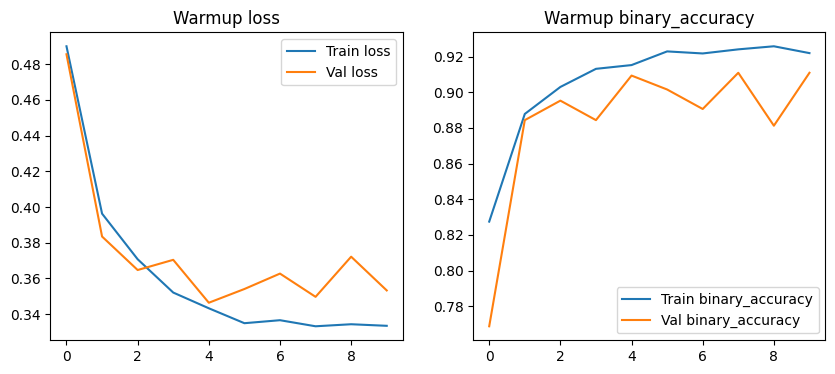

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - binary_accuracy: 0.9342 - loss: 0.3138 - precision: 0.9814 - recall: 0.9296
Epoch 1: val_binary_accuracy improved from -inf to 0.90469, saving model to /content/drive/MyDrive/data/data/efficientnet_binary_robust.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 852ms/step - binary_accuracy: 0.9342 - loss: 0.3138 - precision: 0.9814 - recall: 0.9296 - val_binary_accuracy: 0.9047 - val_loss: 0.3499 - val_precision: 0.9345 - val_recall: 0.9138 - learning_rate: 1.0000e-05
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - binary_accuracy: 0.9416 - loss: 0.3004 - precision: 0.9852 - recall: 0.9363
Epoch 2: val_binary_accuracy improved from 0.90469 to 0.90781, saving model to /content/drive/MyDrive/data/data/efficientnet_binary_robust.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 800ms/step - binary_accuracy: 0.9416 - loss: 0.3004 - precision: 0.9852 - recall: 0.9363 - val_binary_accuracy: 0.9078 - val_loss: 0.3515 - val_precision: 0.9437 - val_re

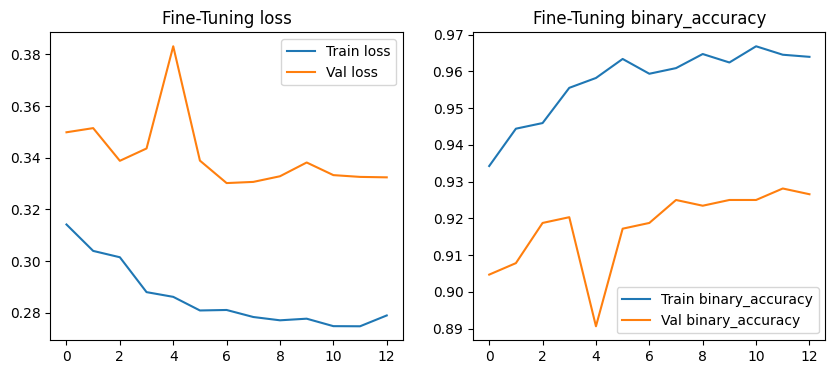

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import logging
import random

# --- CONFIGURATION ---
class Config:
    DATA_DIR = '/content/temp_chest_xray'
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    INPUT_SHAPE = (224, 224, 3)
    SEED = 42

    # Hyperparameters for Overfitting Control
    DROPOUT_RATE = 0.5           # Increased from 0.3 to 0.5
    L2_REG = 0.001               # L2 Regularization factor
    LABEL_SMOOTHING = 0.1        # Prevents over-confident predictions

    LEARNING_RATE_HEAD = 1e-3
    LEARNING_RATE_FINE = 1e-5
    EPOCHS_HEAD = 10             # Increased warmup slightly
    EPOCHS_FINE = 25

    MODEL_NAME = '/content/drive/MyDrive/data/data/efficientnet_binary_robust.keras'
    LOG_DIR = './logs'

def setup_environment(config):
    os.makedirs(config.LOG_DIR, exist_ok=True)
    os.environ['PYTHONHASHSEED'] = str(config.SEED)
    random.seed(config.SEED)
    np.random.seed(config.SEED)
    tf.random.set_seed(config.SEED)
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# --- 1. ROBUST AUGMENTATION PIPELINE ---
def get_data_generators(config):
    logging.info("Initializing Robust Data Generators...")

    # Augmentation strategy specifically for Chest X-Rays
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,

        # Geometry
        rotation_range=15,       # Keep low (lungs don't rotate much in patients)
        width_shift_range=0.1,   # Shift slightly
        height_shift_range=0.1,
        zoom_range=[0.9, 1.1],   # Zoom in/out 10%
        shear_range=0.1,         # Slight perspective change

        # Pixel Level (Crucial for X-rays)
        brightness_range=[0.8, 1.2], # Simulate different X-ray exposures
        channel_shift_range=10.0,    # Slight color shifts (even in grayscale)

        # General
        horizontal_flip=True,    # Lungs are symmetric-ish
        vertical_flip=False,     # NEVER flip X-rays vertically (gravity matters)
        fill_mode='constant',    # Fill empty space with black (0) to match background
        cval=0.0
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    )

    train_gen = train_datagen.flow_from_directory(
        os.path.join(config.DATA_DIR, 'train'),
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        seed=config.SEED
    )

    val_gen = test_datagen.flow_from_directory(
        os.path.join(config.DATA_DIR, 'test'),
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    return train_gen, val_gen

# --- 2. MODEL WITH REGULARIZATION ---
def build_robust_model(config):
    logging.info("Building EfficientNetB0 with L2 Regularization...")

    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=config.INPUT_SHAPE
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    # Increased Dropout to 0.5
    x = Dropout(config.DROPOUT_RATE)(x)

    # Added L2 Regularization to the dense layer
    outputs = Dense(1,
                   activation='sigmoid',
                   kernel_regularizer=regularizers.l2(config.L2_REG),
                   name='prediction')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

def get_class_weights(train_gen):
    weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
    return dict(enumerate(weights))

def plot_history(history, phase=""):
    metrics = ['loss', 'binary_accuracy']
    plt.figure(figsize=(10, 4))
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{phase} {metric}')
        plt.legend()
    plt.show()

# --- MAIN EXECUTION ---
def main():
    config = Config()
    setup_environment(config)

    train_gen, val_gen = get_data_generators(config)
    class_weights = get_class_weights(train_gen)
    model, base_model = build_robust_model(config)

    callbacks = [
        ModelCheckpoint(config.MODEL_NAME, monitor='val_binary_accuracy', save_best_only=True, mode='max', verbose=1),
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
        CSVLogger(os.path.join(config.LOG_DIR, 'training_log.csv'))
    ]

    # Phase 1: Warmup
    logging.info("--- Phase 1: Warmup (Strong Regularization) ---")
    model.compile(
        optimizer=Adam(learning_rate=config.LEARNING_RATE_HEAD),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=config.LABEL_SMOOTHING), # Label Smoothing added
        metrics=['binary_accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )

    history_head = model.fit(train_gen, epochs=config.EPOCHS_HEAD, validation_data=val_gen, class_weight=class_weights)
    plot_history(history_head, "Warmup")

    # Phase 2: Fine-Tuning
    logging.info("--- Phase 2: Fine-Tuning ---")
    base_model.trainable = True

    # Freeze BatchNormalization layers (Critical for Transfer Learning stability)
    for layer in base_model.layers:
        if isinstance(layer, BatchNormalization):
            layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=config.LEARNING_RATE_FINE),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=config.LABEL_SMOOTHING),
        metrics=['binary_accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )

    history_fine = model.fit(
        train_gen,
        epochs=config.EPOCHS_FINE,
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=callbacks
    )
    plot_history(history_fine, "Fine-Tuning")

if __name__ == "__main__":
    main()

Setting up Test Generator...
Found 640 images belonging to 2 classes.
Loading model from /content/drive/MyDrive/data/data/efficientnet_binary_robust.keras...
✅ Model loaded successfully.
Running predictions on Test Set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 303ms/step

       FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL       0.89      0.92      0.90       234
   PNEUMONIA       0.95      0.93      0.94       406

    accuracy                           0.93       640
   macro avg       0.92      0.93      0.92       640
weighted avg       0.93      0.93      0.93       640

Generating Confusion Matrix...


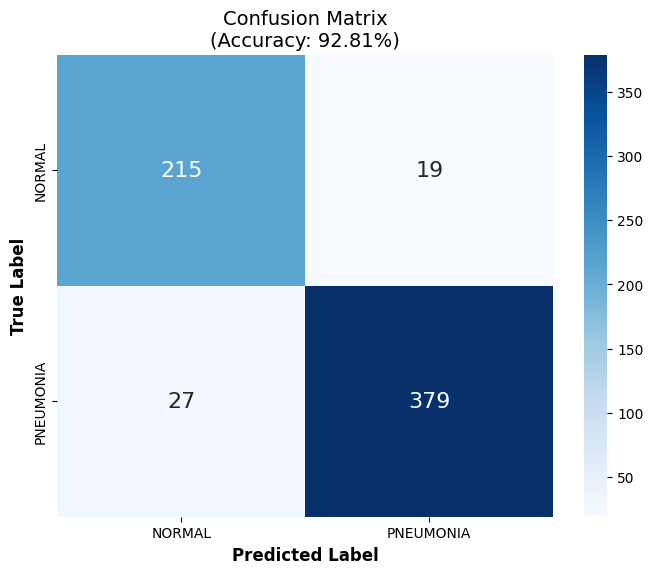

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- CONFIGURATION ---
# 🔴 Update these paths if they are different for you
DATA_DIR = '/content/drive/MyDrive/data/data/chest_xray'
MODEL_PATH = '/content/drive/MyDrive/data/data/efficientnet_binary_robust.keras'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- 1. SETUP TEST DATA GENERATOR ---
print("Setting up Test Generator...")

test_datagen = ImageDataGenerator(
    # CRITICAL: Must use the same preprocessing function as training
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # 🔴 CRITICAL: Must be False to match predictions with true labels
)

# --- 2. LOAD MODEL ---
print(f"Loading model from {MODEL_PATH}...")
try:
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    exit()

# --- 3. RUN PREDICTIONS ---
print("Running predictions on Test Set...")
# This returns probabilities (e.g., 0.02, 0.98)
predictions = model.predict(test_generator, verbose=1)

# Convert probabilities to binary labels (0 or 1)
# Threshold is 0.5 (Standard for Sigmoid)
y_pred = (predictions > 0.5).astype(int).reshape(-1)

# Get True Labels from the generator
y_true = test_generator.classes

# --- 4. CLASSIFICATION REPORT ---
print("\n" + "="*50)
print("       FINAL CLASSIFICATION REPORT")
print("="*50)

# Get class names (should be ['NORMAL', 'PNEUMONIA'])
class_names = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names))

# --- 5. CONFUSION MATRIX ---
print("Generating Confusion Matrix...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 16})

plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix\n(Accuracy: {np.mean(y_true == y_pred):.2%})', fontsize=14)
plt.show()
